<a href="https://colab.research.google.com/github/alexander34ro/AML-Replicating-Novel-Deep-Learning-with-CNN-and-Bi-Directional-LSTM-for-Improved-Index-Prediction/blob/main/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and listed versions

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
print(f'tensorflow=={tf.__version__}')
print(f'pandas=={pd.__version__}')
print(f'numpy=={np.__version__}')
print(f'matplotlib=={matplotlib.__version__}')

tensorflow==1.15.2
pandas==1.1.4
numpy==1.18.5
matplotlib==3.2.2


### Data sources

In [4]:
url_sp500 = 'https://raw.githubusercontent.com/alexander34ro/AML-Replicating-Novel-Deep-Learning-with-CNN-and-Bi-Directional-LSTM-for-Improved-Index-Prediction/main/S%26P500.csv'

In [5]:
df = pd.read_csv(url_sp500, index_col='Date')

## Construct normalized sequences

"Each of the data segments was normalized by subtracting each price in the sequence by the first price in the sequence, then divide by the first price in the sequence. This form of normalization is called relative change."

In [6]:
def relative_change_normalization(data):
  """
  df: pandas.DataFrame

  Returns df where each column is normalized by subtracting the first row of the
  column and then dividing by the first row of the column.
  """
  return data.apply(lambda x: (x - x[0]) / x[0])

In [7]:
def make_sequences(timeseries, sequence_length, target, to_numpy=False):
  """
  timeseries: pandas.Series
  sequence_length: positive integer
  to_numpy: Bool (default=False)

  Returns pandas.DataFrame where each column is name is based on the first day
  of the sequence and holds sequence_length number of consecutive entries of
  timeseries which we call a sequence.
  If to_numpy is True, then convert pandas.DataFrame to numpy array of shape
  (timeseries.size - sequence_length + 1, sequence_length).
  """
  sequence_ix = [np.arange(i, i + sequence_length) for i in np.arange(timeseries.size - (sequence_length + target) + 1)]
  df = pd.DataFrame(columns=timeseries.index[:-(sequence_length+target)+1], 
                    data=np.array([timeseries[ix] for ix in sequence_ix]).T,
                    index=np.arange(sequence_length))
  df = relative_change_normalization(df)
  df.columns.rename('First day of sequence', inplace=True)
  df.index.rename('Day', inplace=True)

  target_values_norm = timeseries[: timeseries.size - (sequence_length + target -1)].values
  target_values = (timeseries[sequence_length + target -1 :] - target_values_norm) / target_values_norm

  if to_numpy:
    return df.to_numpy(dtype=np.float64).T.reshape(df.shape[1],sequence_length,1), target_values.to_numpy(dtype=np.float64).reshape(-1,1)
  else:
    return df, target_values

#### make_sequence usage example: 50 day running mean

In [8]:
seqdf, targ = make_sequences(df['Close'], 50, 7, to_numpy=False)
running_mean_series = seqdf.mean()
seqdf

First day of sequence,2008-01-02,2008-01-03,2008-01-04,2008-01-07,2008-01-08,2008-01-09,2008-01-10,2008-01-11,2008-01-14,2008-01-15,2008-01-16,2008-01-17,2008-01-18,2008-01-22,2008-01-23,2008-01-24,2008-01-25,2008-01-28,2008-01-29,2008-01-30,2008-01-31,2008-02-01,2008-02-04,2008-02-05,2008-02-06,2008-02-07,2008-02-08,2008-02-11,2008-02-12,2008-02-13,2008-02-14,2008-02-15,2008-02-19,2008-02-20,2008-02-21,2008-02-22,2008-02-25,2008-02-26,2008-02-27,2008-02-28,...,2018-07-12,2018-07-13,2018-07-16,2018-07-17,2018-07-18,2018-07-19,2018-07-20,2018-07-23,2018-07-24,2018-07-25,2018-07-26,2018-07-27,2018-07-30,2018-07-31,2018-08-01,2018-08-02,2018-08-03,2018-08-06,2018-08-07,2018-08-08,2018-08-09,2018-08-10,2018-08-13,2018-08-14,2018-08-15,2018-08-16,2018-08-17,2018-08-20,2018-08-21,2018-08-22,2018-08-23,2018-08-24,2018-08-27,2018-08-28,2018-08-29,2018-08-30,2018-08-31,2018-09-04,2018-09-05,2018-09-06
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,-0.024552,0.003223,-0.018352,0.013624,0.007948,-0.013595,0.010871,-0.024925,-0.005612,-0.029093,-0.006045,-0.011085,0.021442,0.010063,-0.015872,0.017548,0.006160,-0.004764,0.016772,0.012237,-0.010463,-0.031995,-0.007624,0.007886,-0.004204,0.005889,0.007266,0.013604,-0.013421,0.000838,-0.000896,0.008341,-0.012867,0.007881,0.013813,0.006918,-0.000919,-0.008942,-0.027090,...,0.001079,-0.001028,0.003974,0.002161,-0.003953,-0.000948,0.001838,0.004781,0.009102,-0.003032,-0.006562,-0.005754,0.004885,-0.001040,0.004926,0.004644,0.003538,0.002824,-0.000262,-0.001442,-0.007114,-0.004006,0.006389,-0.007602,0.007919,0.003323,0.002428,0.002069,-0.000398,-0.001691,0.006199,0.007670,0.000269,0.005701,-0.004430,0.000134,-0.001654,-0.002803,-0.003652,-0.002213
2,-0.024552,-0.021407,-0.015188,-0.004978,0.021681,-0.005755,-0.002873,-0.014325,-0.030397,-0.034541,-0.034962,-0.017064,0.010119,0.031721,-0.005969,0.001398,0.023816,0.001366,0.011928,0.029215,0.001647,-0.042124,-0.039375,0.000202,0.003649,0.001661,0.013198,0.020969,0.000000,-0.012595,-0.000059,0.007437,-0.004634,-0.005088,0.021802,0.020826,0.005992,-0.009853,-0.035789,-0.026571,...,0.000050,0.002941,0.006143,-0.001801,-0.004898,0.000888,0.006628,0.013926,0.006042,-0.009575,-0.012279,-0.000898,0.003839,0.003881,0.009594,0.008199,0.006372,0.002561,-0.001704,-0.008545,-0.011091,0.002358,-0.001261,0.000257,0.011269,0.005759,0.004502,0.001670,-0.002089,0.004497,0.013917,0.007942,0.005972,0.001246,-0.004296,-0.001520,-0.004453,-0.006445,-0.005858,-0.000320
3,-0.021407,-0.039367,-0.001771,0.002930,0.007790,0.005053,-0.027726,-0.019857,-0.058605,-0.040378,-0.045660,0.004013,0.020284,0.015345,0.011475,0.007566,0.018939,0.018162,0.024312,0.018446,-0.030402,-0.049426,-0.031800,-0.004003,0.009559,0.008938,0.026981,0.007266,0.000838,-0.013480,0.008281,-0.005526,0.003210,0.008654,0.028871,0.019888,-0.003003,-0.036676,-0.035275,-0.029927,...,0.004024,0.005108,0.002166,-0.002748,-0.003069,0.005673,0.015790,0.010852,-0.000560,-0.015274,-0.007454,-0.001937,0.008785,0.008543,0.013166,0.011046,0.006108,0.001116,-0.008805,-0.012517,-0.004773,-0.005262,0.006648,0.003581,0.013724,0.007840,0.004102,-0.000025,0.004097,0.012202,0.014190,0.013688,0.001515,0.001380,-0.005944,-0.004319,-0.008089,-0.008644,-0.003971,0.00

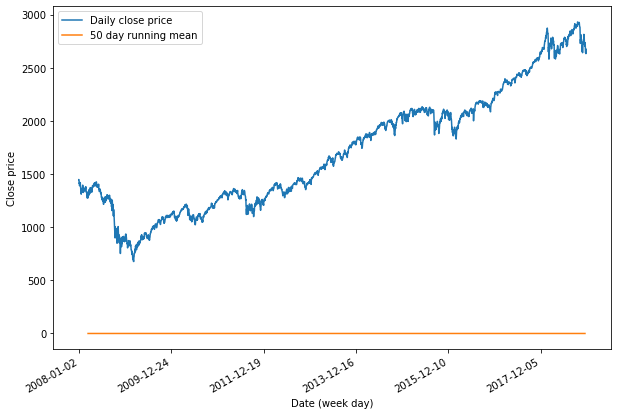

In [9]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10,7))

N = df['Close'].index.size
ind = np.arange(N)  # the evenly spaced plot indices
ind_ = np.arange(running_mean_series.size) + 50

ax.plot(ind, df['Close'], label='Daily close price')
ax.plot(ind_, running_mean_series, label='50 day running mean')

def format_date(x, pos=None):
    thisind = np.clip(int(x + 0.5), 0, N - 1)
    return df.index[thisind]

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
fig.autofmt_xdate()

ax.set_ylabel('Close price')
ax.set_xlabel('Date (week day)')
plt.legend()
plt.show()

#### Relative change normalization
"Each of the data segments was normalized by subtracting each price in the sequence by the first price in the sequence, then divide by the first price in the sequence. This form of normalization is called relative change."

# Rad and split the data

In [10]:
X,y = make_sequences(df['Close'], 50, 7, to_numpy=True)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (2690, 50, 1)
y shape: (2690, 1)


In [11]:
# train, test, val with 0.6, 0.2, 0.2  
xx, x_test, yy, t_test = train_test_split(X,y,test_size=0.2, shuffle=False)
x_train, x_val, t_train, t_val = train_test_split(xx,yy,test_size = 0.25, shuffle=False)

# Define hyper-parameters

In [12]:
cnn_kernel_sizes = 9
n_cnn_filters = 128
hidden_units = 200
dropout_units = 0.25
n_epoch = 500
log_every = 10

In [13]:
weight_initializer = tf.initializers.glorot_uniform
bias_initializer = tf.zeros_initializer

# Utility functions

In [14]:
def conv_1d(x, W, b, s=2):
    x = tf.nn.conv1d(input=x, filters=W, stride=s, padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def maxpool_1d(x, k=2):
    return tf.nn.max_pool1d(x, ksize=2, strides=2, padding='VALID')

# Input and output

In [15]:
x = tf.placeholder(tf.float64, [None, 50, 1])
t = tf.placeholder(tf.float64, [None, 1])

x_v = tf.placeholder(tf.float64, [None, 50, 1])
t_v = tf.placeholder(tf.float64, [None, 1])

# Defined the model parameters

In [16]:
Wc1 = tf.get_variable('Wc1', [cnn_kernel_sizes, 1, n_cnn_filters], initializer=weight_initializer, dtype=tf.float64) 
Wc2 = tf.get_variable('Wc2', [cnn_kernel_sizes, n_cnn_filters, n_cnn_filters*2], initializer=weight_initializer, dtype=tf.float64) 
Wc3 = tf.get_variable('Wc3', [cnn_kernel_sizes, n_cnn_filters*2, n_cnn_filters*4], initializer=weight_initializer, dtype=tf.float64)
Wd = tf.get_variable('Wd', [400, 1], initializer=weight_initializer, dtype=tf.float64)

Bc1 = tf.get_variable('Bc1', [n_cnn_filters], initializer=bias_initializer, dtype=tf.float64)
Bc2 = tf.get_variable('Bc2', [n_cnn_filters*2], initializer=bias_initializer, dtype=tf.float64)
Bc3 = tf.get_variable('Bc3', [n_cnn_filters*4], initializer=bias_initializer, dtype=tf.float64)
Bd = tf.get_variable('Bd', [1], initializer=bias_initializer, dtype=tf.float64)

# Construct model

In [17]:
Zc1 = tf.nn.relu(conv_1d(x_train, Wc1, Bc1))
Zc1 = maxpool_1d(Zc1)
Zc2 = tf.nn.relu(conv_1d(Zc1, Wc2, Bc2))
Zc2 = maxpool_1d(Zc2)
Zc3 = tf.nn.relu(conv_1d(Zc2, Wc3, Bc3))
Zc3 = maxpool_1d(Zc3)

lstm_fw_cell_1 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units) 
lstm_bw_cell_1 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
with tf.variable_scope('lstm1'):
  outputs1, _= tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell_1, lstm_bw_cell_1, Zc3, dtype='float64')

conc1 = tf.concat(values=outputs1, axis=2)
tf.nn.dropout(conc1, rate=dropout_units)

lstm_fw_cell_2 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
lstm_bw_cell_2 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
with tf.variable_scope('lstm2'):
  outputs2, _ = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell_2, lstm_bw_cell_2, conc1, dtype='float64')

conc2 = tf.concat(values=outputs2, axis=2)
tf.nn.dropout(conc2, rate=dropout_units*2)

fc = tf.reshape(conc2, [-1, hidden_units * 2])
fc = tf.add(tf.matmul(fc, Wd), Bd)
y = tf.nn.relu(fc)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
Zc11 = tf.nn.relu(conv_1d(x_val, Wc1, Bc1))
Zc11 = maxpool_1d(Zc11)
Zc22 = tf.nn.relu(conv_1d(Zc11, Wc2, Bc2))
Zc22 = maxpool_1d(Zc22)
Zc33 = tf.nn.relu(conv_1d(Zc22, Wc3, Bc3))
Zc33 = maxpool_1d(Zc33)

lstm_fw_cell_11 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
lstm_bw_cell_11 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
with tf.variable_scope('lstm11'):
  outputs11, _ = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell_11, lstm_bw_cell_11, Zc33, dtype='float64')
conc11 = tf.concat(values=outputs11, axis=2)
tf.nn.dropout(conc11, rate=dropout_units)

lstm_fw_cell_22 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
lstm_bw_cell_22 = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
with tf.variable_scope('lstm22'):
  outputs22, _ = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell_22, lstm_bw_cell_22, conc11, dtype='float64')
conc22 = tf.concat(values=outputs22, axis=2)
tf.nn.dropout(conc22, rate=dropout_units*2)

fc1 = tf.reshape(conc22, [-1, hidden_units * 2])
fc1 = tf.add(tf.matmul(fc1, Wd), Bd)
y_val = tf.nn.relu(fc1)

# Define the loss function and the optimizer operation

In [19]:
loss = tf.losses.mean_squared_error(labels=t, predictions=y)
loss_val = tf.losses.mean_squared_error(labels=t_val, predictions=y_val)

optimizer = tf.train.AdadeltaOptimizer().minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training

In [ ]:
init = tf.global_variables_initializer()

train_loss_list = []
val_loss_list = []
best_val_loss = np.float('inf')
saver = tf.train.Saver()

with tf.Session() as session:
    session.run(init)
    
    for epoch in range(n_epoch):
        _, loss_value = session.run([optimizer, loss], feed_dict={x: x_train, t: t_train})
        val_loss_value = session.run(loss_val, feed_dict={x_v: x_val, t_v: t_val})

        if val_loss_value < best_val_loss:
            best_val_loss = val_loss_value
            saver.save(sess=session, save_path="./model")
        
        train_loss_list.append(loss_value)
        val_loss_list.append(val_loss_value)
        
        if epoch % 1 == 0:
            print("Epoch: ", epoch, "loss =", loss_value)            
            
    print("Optimization done")

Epoch:  0 loss = 0.008389753
Epoch:  1 loss = 0.008389732
Epoch:  2 loss = 0.008389696
Epoch:  3 loss = 0.008389628
Epoch:  4 loss = 0.008389519
Epoch:  5 loss = 0.008389363
Epoch:  6 loss = 0.008389169
Epoch:  7 loss = 0.008388932
Epoch:  8 loss = 0.008388672
Epoch:  9 loss = 0.008388394
Epoch:  10 loss = 0.008388111
Epoch:  11 loss = 0.00838783
Epoch:  12 loss = 0.008387552
Epoch:  13 loss = 0.008387279
Epoch:  14 loss = 0.008387012
Epoch:  15 loss = 0.0083867535
Epoch:  16 loss = 0.008386507
Epoch:  17 loss = 0.008386268
Epoch:  18 loss = 0.008386031
Epoch:  19 loss = 0.008385799
Epoch:  20 loss = 0.008385571
Epoch:  21 loss = 0.008385352
Epoch:  22 loss = 0.008385139
Epoch:  23 loss = 0.008384932
Epoch:  24 loss = 0.008384725
Epoch:  25 loss = 0.008384522
Epoch:  26 loss = 0.008384326
Epoch:  27 loss = 0.008384138
Epoch:  28 loss = 0.008383956
Epoch:  29 loss = 0.008383774
Epoch:  30 loss = 0.008383596
Epoch:  31 loss = 0.008383425
Epoch:  32 loss = 0.008383255
Epoch:  33 loss = 0.

In [ ]:
train_loss_list

# Plot Training loss and Validation loss

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
# ax.plot(range(len(train_loss_list)), train_loss_list, label="Training loss")
ax.plot(range(len(val_loss_list)), val_loss_list, label="Validation loss")
ax.legend()
# ax.set_ylim(0, 0.02)
ax.set_xlabel(r'epoch')
ax.set_ylabel(r'loss')
plt.show()